# Preprocesamiento Automatizado de Datos

Este cuaderno implementa un pipeline de preprocesamiento automatizado para una base de datos.
El objetivo principal es garantizar la calidad de los datos, evaluando su completitud y coherencia, mientras se realiza una limpieza y transformación para análisis posteriores.


In [1]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


In [2]:
# Crear un pipeline de preprocesamiento
# 1. Clase personalizada para manejar valores faltantes
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """
    Clase personalizada para manejar valores faltantes en un dataset.
    Se puede seleccionar una estrategia para llenar los valores faltantes
    en las columnas especificadas.
    
    Parámetros
    
    strategy: str
        Estrategia para llenar los valores faltantes. Puede ser "mean", "median" o "mode".
        
        
    columns: list
        Lista de columnas en las que se llenarán los valores faltantes.


    Métodos
    fit(self, X, y=None)
        Ajusta la estrategia de llenado de valores faltantes.
        
    transform(self, X)
        Llena los valores faltantes en las columnas especificadas.
    
    """
    def __init__(self, strategy="mean", columns=None):
        self.strategy = strategy
        self.columns = columns

    def fit(self, X, y=None):
        """
        Ajusta la transformación de las columnas especificadas a tipo numérico.

        Parámetros
        
        X: DataFrame
            Dataset de entrenamiento.
            
        y: None
            No se utiliza en esta clase.
                    
        Retorna
        self: objeto
            Instancia de la clase ConvertToNumeric.
        """
        if self.columns is None:
            self.columns = X.columns
        if self.strategy == "mean":
            self.fill_values_ = X[self.columns].mean()
        elif self.strategy == "median":
            self.fill_values_ = X[self.columns].median()
        elif self.strategy == "mode":
            self.fill_values_ = X[self.columns].mode().iloc[0]
        return self

    def transform(self, X):
        """
        Convierte las columnas especificadas a tipo numérico.
        
        Parámetros

        X: DataFrame
            Dataset a transformar.
        
        Retorna
        X: DataFrame
            Dataset transformado.            
        """
        X = X.copy()
        for col in self.columns:
            X[col].fillna(self.fill_values_[col], inplace=True)
        return X

# 2. Clase personalizada para convertir datos a tipo numérico
class ConvertToNumeric(BaseEstimator, TransformerMixin):
    """
    Clase personalizada para convertir columnas de un dataset a tipo numérico.
    
    Parámetros
    -----------
    columns: list
        Lista de columnas a convertir a tipo numérico.
        
    Métodos
    -----------
    fit(self, X, y=None)
        Ajusta la transformación de las columnas especificadas a tipo numérico.
        
    transform(self, X)
        Convierte las columnas especificadas a tipo numérico.
    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        """
        Ajusta la transformación de las columnas especificadas a tipo numérico.

        Parámetros
        
        X: DataFrame
            Dataset de entrenamiento.
            
        y: None
            No se utiliza en esta clase.
                    
        Retorna
        self: objeto
            Instancia de la clase ConvertToNumeric.
        """
        return self

    def transform(self, X):
        """
        Convierte las columnas especificadas a tipo numérico.
        
        Parámetros

        X: DataFrame
            Dataset a transformar.
        
        Retorna
        X: DataFrame
            Dataset transformado.            
        """
        X = X.copy()
        for col in self.columns:
            X[col] = pd.to_numeric(X[col].astype(str).str.replace(",", ""), errors="coerce")
        return X

# 3. Clase personalizada para manejar datos temporales
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    Clase personalizada para manejar columnas de fechas en un dataset.
    
    Parámetros
    -----------
    date_column: str
        Nombre de la columna con fechas.
        
    Métodos
    -----------
    fit(self, X, y=None)
        Ajusta la transformación de las columnas especificadas a tipo numérico.
        
    transform(self, X)
        Convierte las columnas especificadas a tipo numérico.    
    """
    def __init__(self, date_column="Date"):
        self.date_column = date_column

    def fit(self, X, y=None):
        """
        Ajusta la transformación de las columnas especificadas a tipo numérico.

        Parámetros
        
        X: DataFrame
            Dataset de entrenamiento.
            
        y: None
            No se utiliza en esta clase.
                    
        Retorna
        self: objeto
            Instancia de la clase ConvertToNumeric.
        """
        return self

    def transform(self, X):
        """
        Convierte las columnas especificadas a tipo numérico.
        
        Parámetros

        X: DataFrame
            Dataset a transformar.
        
        Retorna
        X: DataFrame
            Dataset transformado.            
        """
        X = X.copy()
        X[self.date_column] = pd.to_datetime(X[self.date_column])
        X["Year"] = X[self.date_column].dt.year
        X["Month"] = X[self.date_column].dt.month
        X["Day"] = X[self.date_column].dt.day
        return X

# 4. Clase personalizada para eliminar valores atípicos
class OutlierRemover(BaseEstimator, TransformerMixin):
    """
    Clase personalizada para eliminar valores atípicos en un dataset.

    Parámetros
    -----------
    columns: list
        Lista de columnas en las que se eliminar los valores atípicos.
        
    Métodos
    -----------
    fit(self, X, y=None)
        Ajusta la transformación de las columnas especificadas a tipo numérico.
        
    transform(self, X)
        Elimina los valores atípicos en las columnas especificadas.
    """
    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, y=None):
        """
        Ajusta la transformación de las columnas especificadas a tipo numérico.

        Parámetros
        
        X: DataFrame
            Dataset de entrenamiento.
            
        y: None
            No se utiliza en esta clase.
                    
        Retorna
        self: objeto
            Instancia de la clase ConvertToNumeric.
        """
        return self

    def transform(self, X):
        """
        Convierte las columnas especificadas a tipo numérico.

        Parámetros
        
        X: DataFrame
            Dataset a transformar.

        Retorna
        X: DataFrame
            Dataset transformado.
        """
        X = X.copy()
        for col in self.columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            X = X[(X[col] >= lower_bound) & (X[col] <= upper_bound)]
        return X

# 5. Función para cargar y previsualizar datos
def load_and_preview(file_path):
    """
    Carga un dataset y muestra las primeras filas y la información del dataset.
    
    Parámetros
    -----------
    file_path: str
        Ruta del archivo CSV a cargar.
        
    Retorna
    -----------
    df: DataFrame
        Dataset cargado.
    """
    df = pd.read_csv(file_path)
    print("\nDatos cargados con éxito\n")
    print(df.head())
    print("\nInformación del dataset:\n")
    print(df.info())
    return df

# 6. Pipeline de preprocesamiento
def preprocess_data(df):
    """
    Preprocesa un dataset aplicando un pipeline de transformaciones.
    
    Parámetros
    -----------
    df: DataFrame
        Dataset a preprocesar.
    
    Retorna
    -----------
    df: DataFrame
        Dataset preprocesado.
    """
    pipeline = Pipeline([
        ("missing_handler", MissingValueHandler(strategy="mean", columns=["Adj Close", "Close", "High", "Low", "Open", "Volume"])),
        ("numeric_converter", ConvertToNumeric(columns=["Adj Close", "Close", "High", "Low", "Open", "Volume"])),
        ("date_transformer", DateTransformer(date_column="Date")),
        ("outlier_remover", OutlierRemover(columns=["Adj Close", "Close", "High", "Low", "Open", "Volume"]))
    ])
    return pipeline.fit_transform(df)

# 7. Visualización de datos limpios
def visualize_data(df):
    """
    Visualiza la tendencia histórica del precio ajustado y la distribución de precios.
    
    Parámetros
    -----------
    df: DataFrame
        Dataset a visualizar.
    """
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x="Date", y="Adj Close", label="Adjusted Close")
    plt.title("Tendencia histórica del precio ajustado")
    plt.xlabel("Fecha")
    plt.ylabel("Precio ajustado (USD)")
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[["Adj Close", "Close", "High", "Low", "Open"]])
    plt.title("Distribución de precios")
    plt.show()

# 8. Análisis resumen
def analyze_summary(df):
    """
    Muestra un resumen estadístico y la cantidad de registros por año.

    Parámetros
    -----------
    df: DataFrame
        Dataset a analizar.
    """
    print("\nResumen estadístico:\n")
    print(df.describe())
    print("\nRegistros por año:\n")
    print(df.groupby("Year").size())

## 1. Carga de Datos

### Acerca del conjunto de datos
📊 Conjunto de datos de acciones de Toyota (1980-2024)\
🌟 Este conjunto de datos ofrece datos diarios de transacciones bursátiles de Toyota Motor Corporation (ticker: TM) desde 1980 hasta 2024, obtenidos de Yahoo Finance. Proporciona un registro extenso del desempeño de las acciones de Toyota durante más de cuatro décadas, con métricas esenciales como precios de cierre ajustados, precios de apertura/cierre, máximos, mínimos y volúmenes de transacciones.

📄Descripción general del conjunto de datos\
🗓️ Período de tiempo: 1980 a 2024\
📈 Registros totales: más de 11 000 filas (según las actualizaciones)\
📂 Tamaño del archivo: ~778 KB\
Este conjunto de datos es perfecto para análisis financieros, pronósticos de series temporales y aplicaciones de aprendizaje automático para explorar las tendencias de los precios de las acciones y el comportamiento del mercado.

📋 Columnas y descripciones\
🏷️ Columna 🔍 Descripción\
📅 Fecha La fecha de negociación en formato AAAA-MM-DD.\
📉 Cierre ajustado El precio de cierre ajustado, que tiene en cuenta acciones corporativas como divisiones o dividendos.\
🔒 Cierre El precio de cierre oficial de las acciones de Toyota en el día determinado.\
📈 Máximo El precio más alto de la acción durante la sesión de negociación.\
📉 Mínimo El precio más bajo de la acción durante la sesión de negociación.\
🔓 Apertura El precio de apertura de las acciones de Toyota en el día determinado.\
🔄 Volumen El número total de acciones negociadas durante el día.

🌟 Características principales\
Completo y confiable: conjunto de datos integral sin valores faltantes.\
Décadas de datos: una perspectiva histórica detallada del rendimiento de las acciones de Toyota desde 1980 hasta 2024.\
Listo para usar: ideal para modelado de series temporales, pronósticos financieros y análisis exploratorio de datos (EDA).

🚀 Aplicaciones\
📊 Análisis de precios de acciones: identifica tendencias, picos y valles en los precios de las acciones de Toyota a lo largo de los años.\
🤖 Aprendizaje automático: entrena modelos predictivos para futuros pronósticos de precios y análisis de mercado.\
📈 Optimización de cartera: evalúa el rendimiento de las acciones de Toyota como parte de una cartera de inversiones diversificada.\
🔎 Investigación de mercado: estudia el impacto de los eventos globales y los factores económicos en el rendimiento de las acciones de Toyota.

No dudes en explorar este conjunto de datos y aprovechar sus valiosos conocimientos para tus proyectos financieros y de aprendizaje automático. 🚗✨

Enlace: https://www.kaggle.com/datasets/mhassansaboor/toyota-motors-stock-data-2980-2024/data (Toyota Motors Stock Data (1980-2024)
Toyota Motors Stock Dataset from (1980-2024))

Cargamos los datos desde un archivo `.csv` y realizamos una inspección inicial.


In [2]:
# Descarga de la base de datos
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mhassansaboor/toyota-motors-stock-data-2980-2024")

# print("Path to dataset files:", path)

100%|██████████| 189k/189k [00:00<00:00, 900kB/s]

Extracting files...
Path to dataset files: C:\Users\frany\.cache\kagglehub\datasets\mhassansaboor\toyota-motors-stock-data-2980-2024\versions\1


In [3]:
file_path = "./data/Toyota_Data.csv"  # Cambia este archivo por la ruta adecuada

# Cargar y previsualizar los datos
df = load_and_preview(file_path)

# Inspeccionar las primeras filas
print(df.head())

# Resumen estadístico
print(df.info())



Datos cargados con éxito

         Date  Adj Close     Close      High       Low      Open  Volume
0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   41109
1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000    9343
2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606       0
3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   10277
4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000    8409

Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11291 non-null  object 
 1   Adj Close  11291 non-null  float64
 2   Close      11291 non-null  float64
 3   High       11291 non-null  float64
 4   Low        11291 non-null  float64
 5   Open       11291 non-null  float64
 6   Volume     11291 non-null  int64  
dtypes: float64(5), int64(1), object(1)


## 2. Tratamiento de Datos Faltantes y Normalización de Datos

- Utilizamos un imputador para manejar los valores nulos en los datos.
- Escalamos los datos para que estén en un rango uniforme usando `MinMaxScaler`.


In [4]:
# Preprocesar los datos
clean_df = preprocess_data(df)

C:\Users\frany\AppData\Local\Temp\ipykernel_1496\564821866.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(self.fill_values_[col], inplace=True)


## 3. Visualización de Datos Limpios

Visualizamos la distribución de las columnas y las relaciones entre ellas.


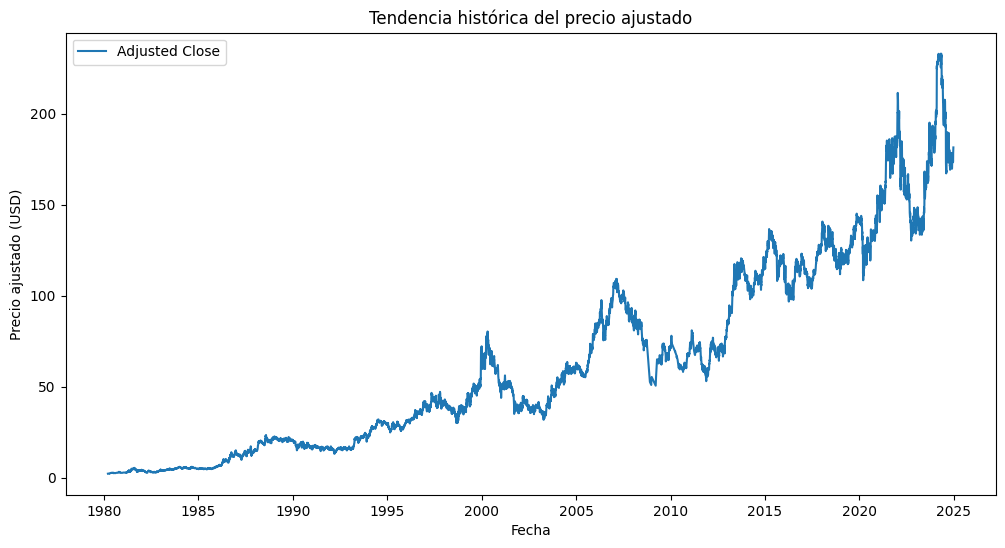

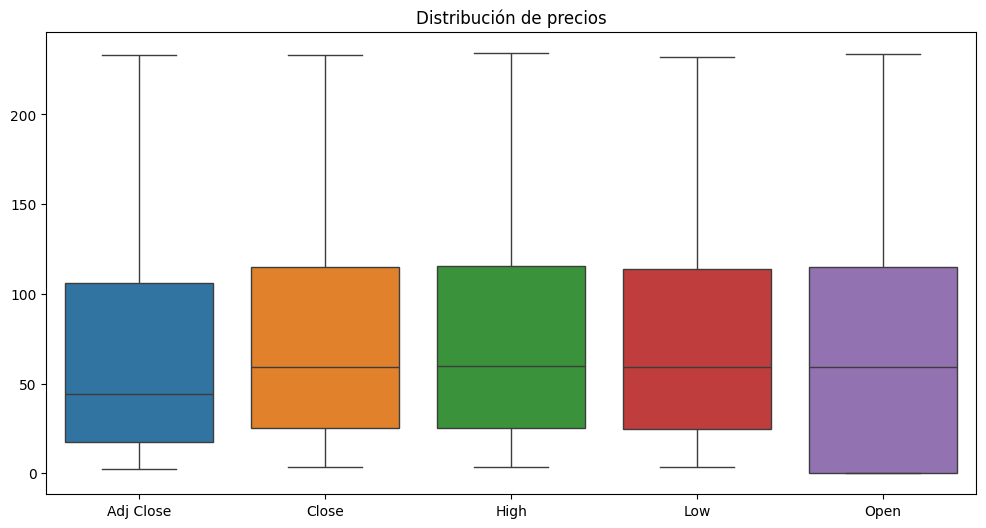

In [5]:
# Visualizar datos limpios
visualize_data(clean_df)


## 4. Evaluación de Consistencia

Comprobamos la coherencia de los campos, como fechas y rangos esperados.


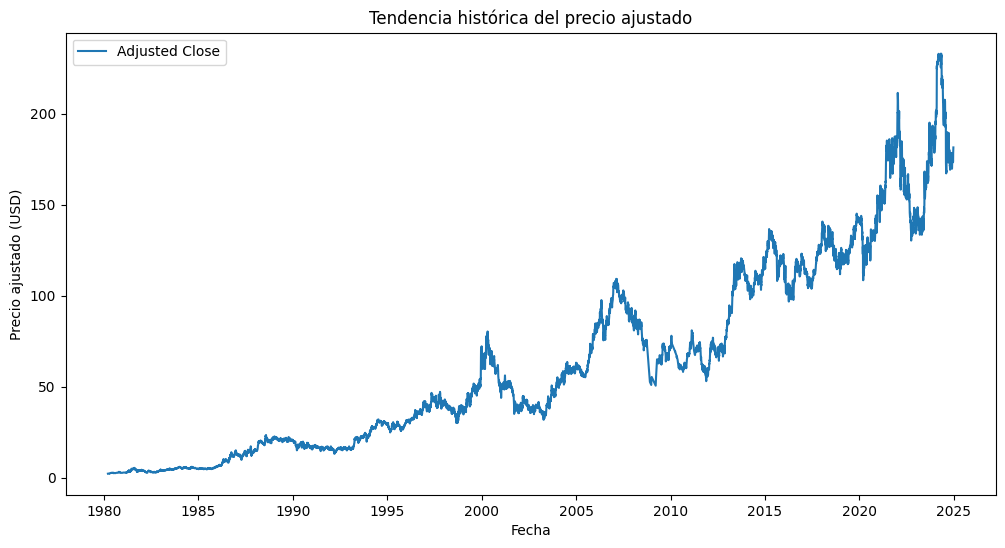

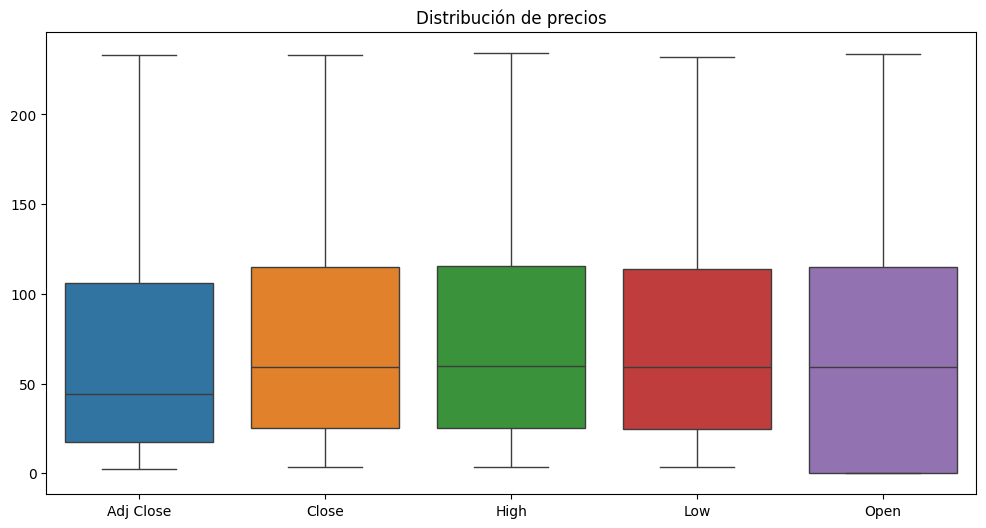

In [6]:
# Visualizar datos limpios
visualize_data(clean_df)

## 6. Pipeline completo

Realizar el proceso de una función con el proceso automáfico de la base de datos


Datos cargados con éxito

         Date  Adj Close     Close      High       Low      Open  Volume
0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   41109
1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000    9343
2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606       0
3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   10277
4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000    8409

Información del dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11291 entries, 0 to 11290
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       11291 non-null  object 
 1   Adj Close  11291 non-null  float64
 2   Close      11291 non-null  float64
 3   High       11291 non-null  float64
 4   Low        11291 non-null  float64
 5   Open       11291 non-null  float64
 6   Volume     11291 non-null  int64  
dtypes: float64(5), int64(1), object(1)


C:\Users\frany\AppData\Local\Temp\ipykernel_1496\564821866.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(self.fill_values_[col], inplace=True)


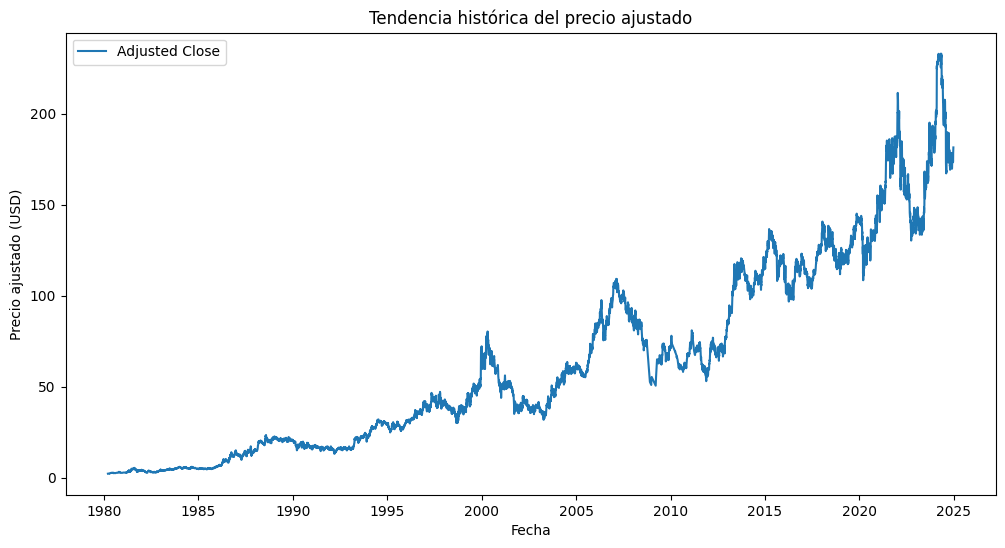

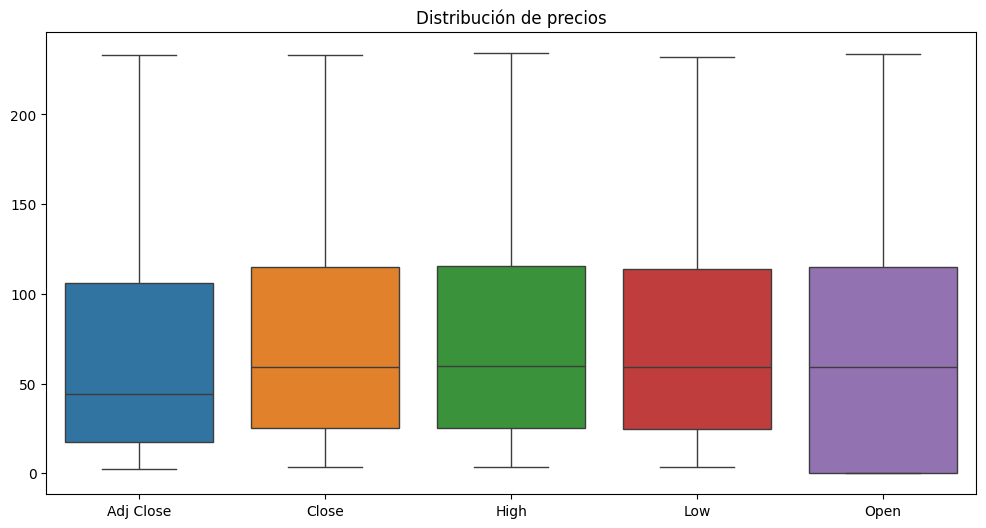


Resumen estadístico:

                                Date     Adj Close         Close  \
count                          10574  10574.000000  10574.000000   
mean   2002-01-03 10:24:48.481180160     62.143933     70.386942   
min              1980-03-17 00:00:00      2.259452      3.237711   
25%              1990-09-10 06:00:00     17.446363     25.000000   
50%              2001-02-26 12:00:00     44.010897     59.500000   
75%              2014-02-11 18:00:00    105.987251    114.737499   
max              2024-12-24 00:00:00    232.880005    232.880005   
std                              NaN     52.437067     51.398233   

               High           Low          Open         Volume          Year  \
count  10574.000000  10574.000000  10574.000000   10574.000000  10574.000000   
mean      70.773704     70.021223     66.014345  150787.415737   2001.499433   
min        3.237711      3.237711      0.000000       0.000000   1980.000000   
25%       25.227274     24.922521      0.000

In [7]:
# Ejecución principal
if __name__ == "__main__":
    file_path = "./data/Toyota_Data.csv"  # Cambia este archivo por la ruta adecuada

    # Cargar y previsualizar los datos
    df = load_and_preview(file_path)

    # Preprocesar los datos
    clean_df = preprocess_data(df)

    # Visualizar datos limpios
    visualize_data(clean_df)

    # Analizar resumen
    analyze_summary(clean_df)